# 1. Introduzione

L'obiettivo di questo studio è analizzare il fenomeno dell'abbandono dei clienti (churn) in ambito bancario. Il *churn rate* è una metrica critica per le istituzioni finanziarie, poiché acquisire un nuovo cliente è spesso molto più costoso che mantenerne uno esistente.

Gli scopi principali della nostra analisi sono:
1. **Identificare e visualizzare i fattori** che contribuiscono maggiormente all'abbandono dei clienti.
2. **Costruire un modello predittivo** in grado di:
    * Classificare se un cliente è a rischio di abbandono.
    * Associare una probabilità al churn, consentendo al servizio clienti di prioritizzare gli interventi sulle fasce di rischio più alte.

## 2. Revisione e preparazione del set di dati

In questa sezione esploreremo la struttura dei dati per comprendere lo spazio di input e preparare il dataset per le fasi successive di analisi esplorativa e modellazione predittiva.

In [3]:
## REQUIRED LIBRARIES
# For data wrangling 
import numpy as np
import pandas as pd

# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

Carichiamo il dataset per valutarne le dimensioni iniziali. Il file contiene informazioni su 10.000 clienti con 14 attributi diversi.

In [4]:
# Read the data frame
df = pd.read_csv('Churn_Modelling.csv', delimiter=',')
df.shape

(10000, 14)

Prima di procedere, è fondamentale verificare la presenza di valori mancanti. La gestione dei dati nulli è un passaggio critico nella data science, poiché la maggior parte degli algoritmi di machine learning non può gestire input incompleti.

In [5]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [43]:
# Check columns list and missing values
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Incredibilmente, il dataset non presenta valori mancanti. Ora analizziamo il numero di valori univoci per ogni colonna per identificare variabili che potrebbero non aggiungere valore predittivo (come ID univoci).

In [44]:
# Get unique count for each variable
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

Dall'analisi dei valori univoci, emerge che `RowNumber` e `CustomerId` sono identificativi specifici per ogni riga e non possono aiutare il modello a generalizzare. Anche il cognome (`Surname`) viene escluso per evitare profilazioni basate su dati non statistici e per ridurre il rumore nel modello.

In [45]:
# Drop the columns as explained above
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

Visualizziamo ora le prime righe del dataframe pulito per assicurarci che la struttura sia corretta.

In [46]:
# Review the top rows of what is left of the data frame
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Riflessioni sul Dataset
Dall'anteprima sorgono alcune questioni metodologiche:
1. **Snapshot temporale**: I dati sembrano una "fotografia" in un dato istante. Sarebbe più utile avere una serie storica dei saldi per rilevare trend di diminuzione.
2. **Saldo positivo dopo il churn**: Notiamo che alcuni clienti che hanno abbandonato (`Exited=1`) hanno ancora un saldo sul conto. Ciò suggerisce che potrebbero aver chiuso solo alcuni prodotti o che il dato si riferisca a un istante precedente la chiusura definitiva.
3. **Membri attivi**: La definizione di "membro attivo" è binaria. Dati più granulari sul numero di transazioni mensili fornirebbero una visione molto più chiara dell'engagement del cliente.

Nonostante queste limitazioni, procederemo con la modellazione utilizzando le informazioni disponibili.

In [47]:
# Check variable data types
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

## 3. Analisi Esplorativa dei Dati (EDA)

In questa fase, cerchiamo di capire come i vari attributi influenzano la probabilità che un cliente abbandoni la banca. Iniziamo analizzando la variabile target `Exited`.

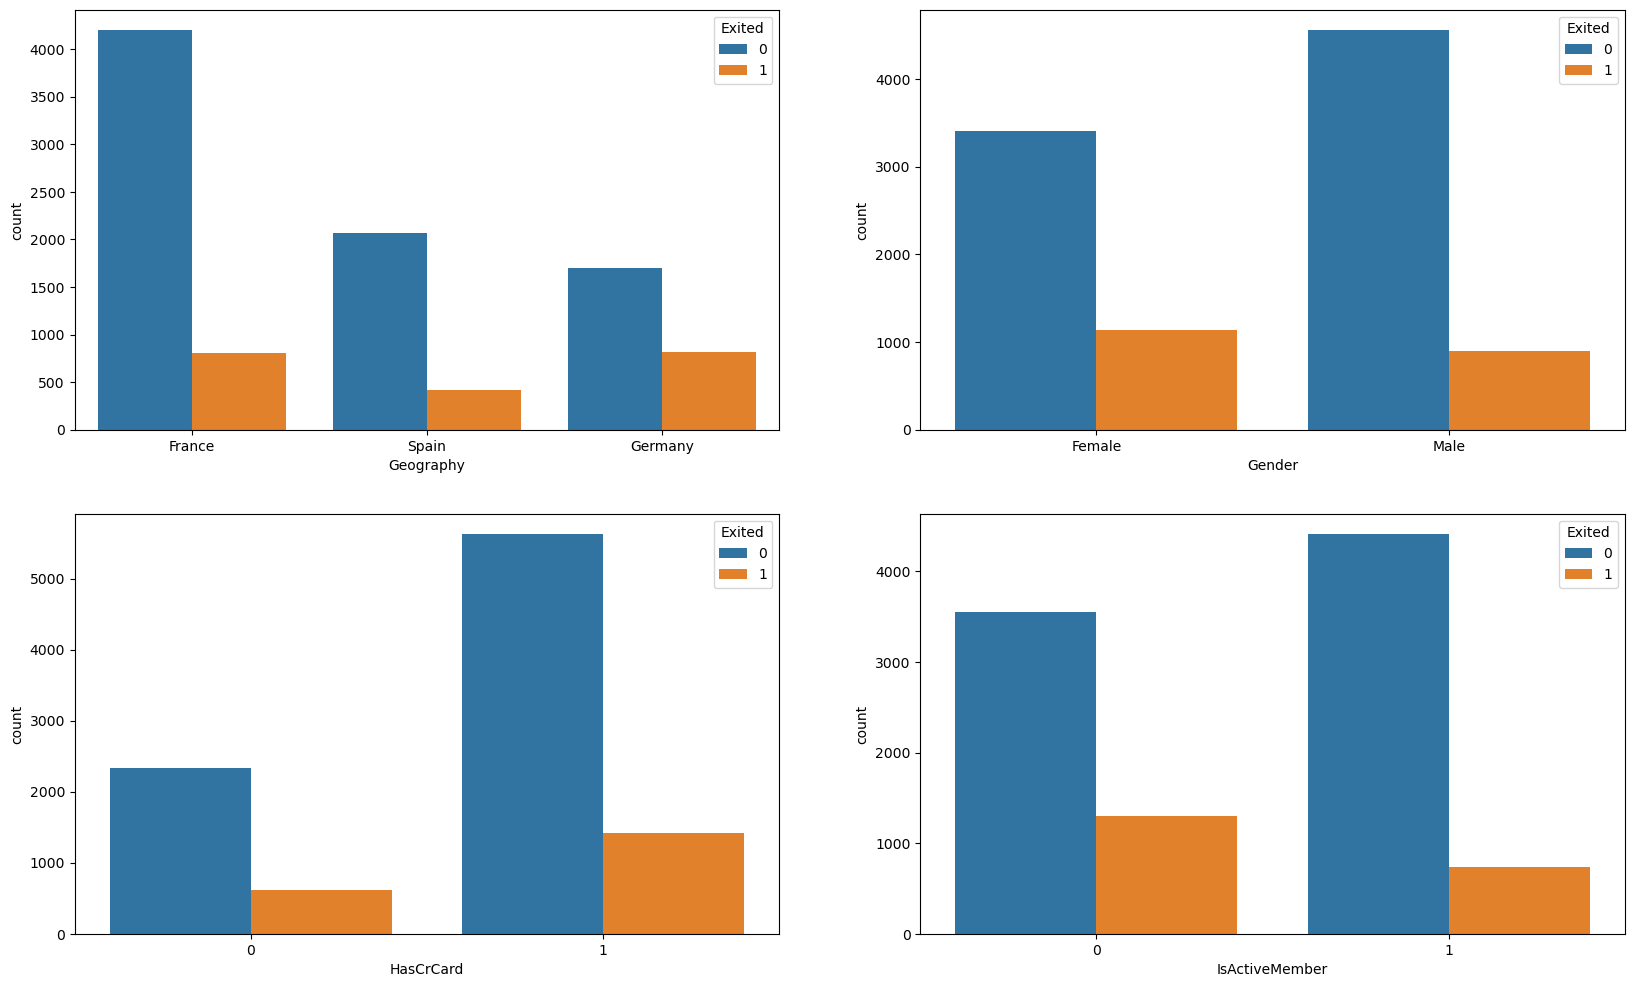

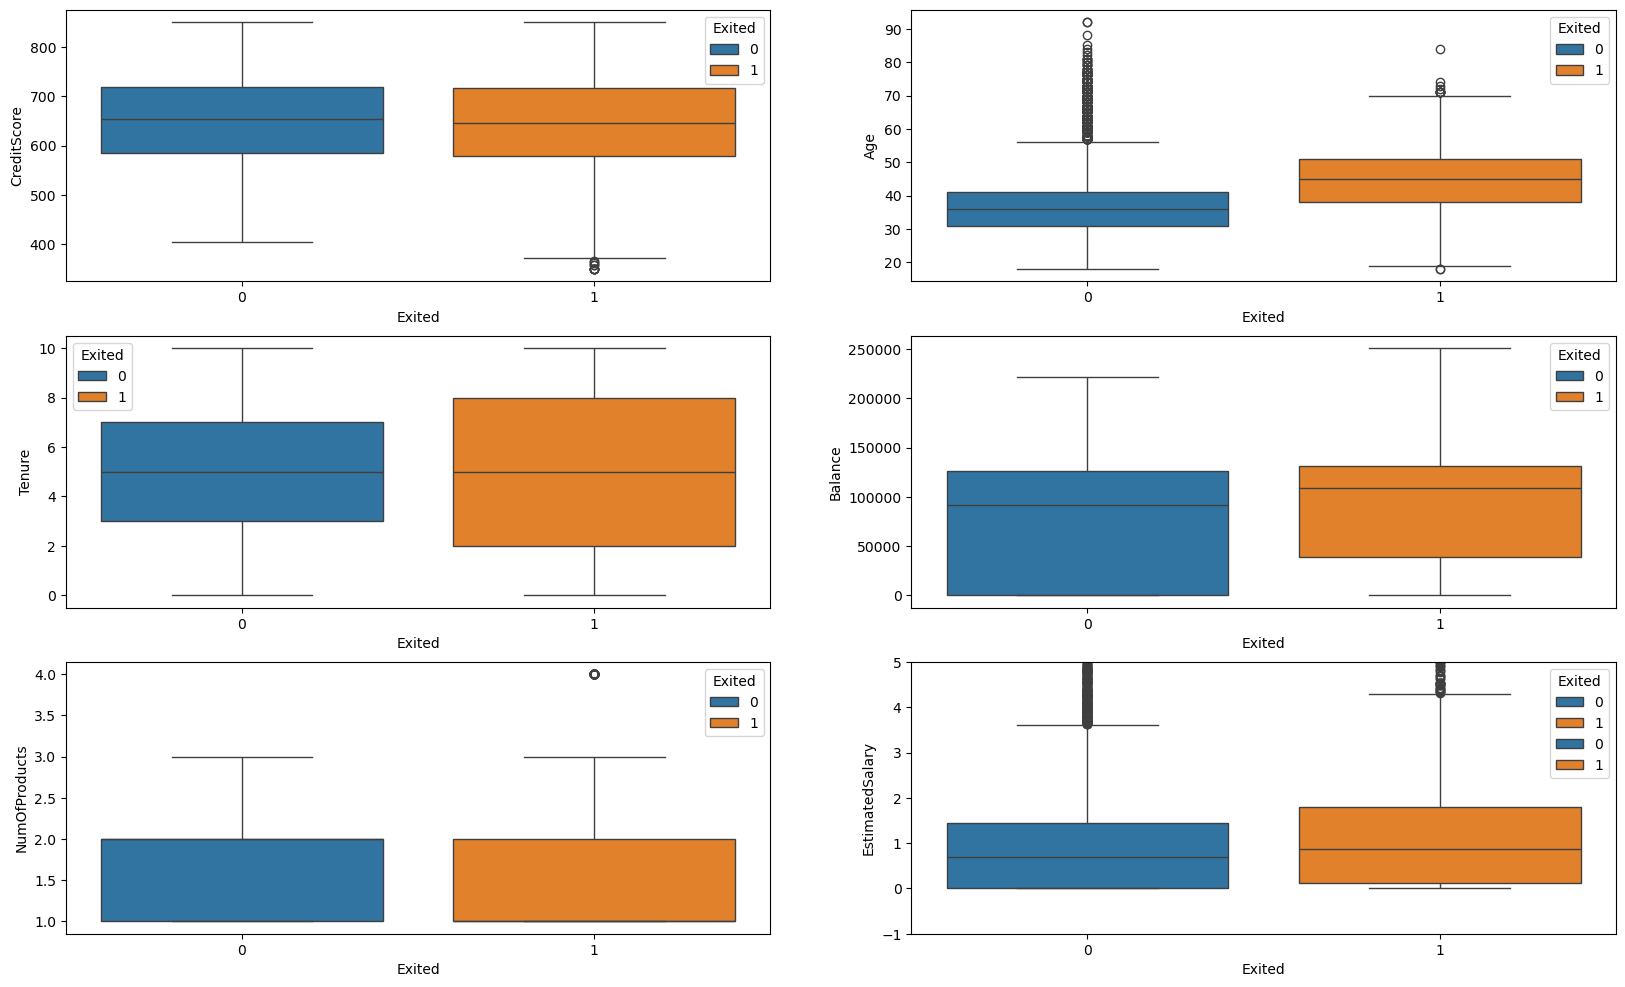

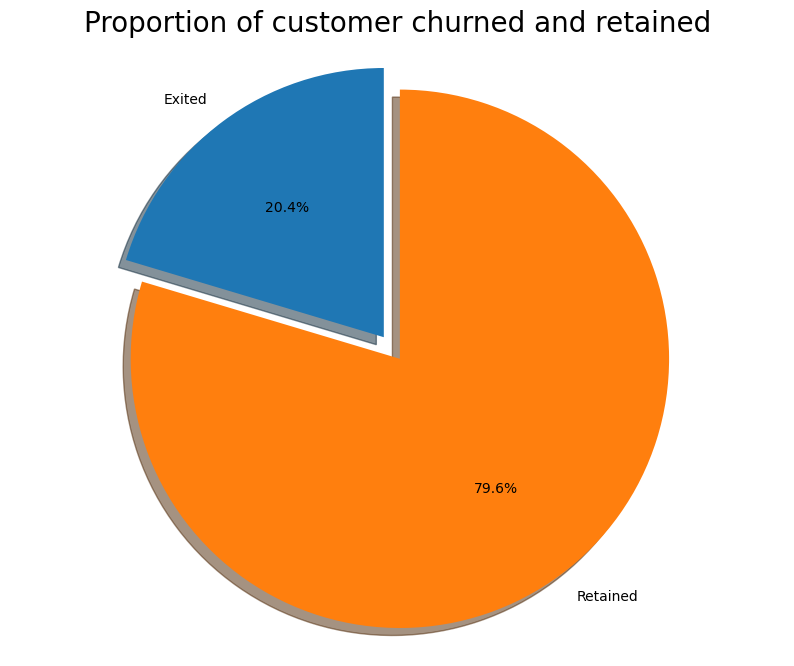

In [48]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

Circa il **20,4%** dei clienti ha abbandonato la banca. Questo indica un dataset parzialmente sbilanciato. Un modello che predicesse sempre "non abbandona" avrebbe un'accuratezza dell'80% circa, ma sarebbe inutile per gli scopi della banca. Dobbiamo assicurarci che il modello sia sensibile all'identificazione di quel 20% critico.

In [49]:
    # We first review the 'Status' relation with categorical variables
    fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
    sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
    sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
    sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
    sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

<Axes: xlabel='IsActiveMember', ylabel='count'>

### Osservazioni sulle variabili categoriali:
* **Geografia**: La Francia ha il maggior numero di clienti, ma la Germania mostra una proporzione di churn significativamente più alta. Questo potrebbe indicare problemi competitivi o di servizio specifici per il mercato tedesco.
* **Genere**: Le donne tendono ad abbandonare più degli uomini.
* **Carta di Credito**: La maggior parte dei clienti che abbandonano possiede una carta di credito, ma ciò riflette semplicemente la diffusione dello strumento nel dataset totale.
* **Membro Attivo**: Come previsto, i membri non attivi hanno un tasso di churn molto più elevato. La banca dovrebbe concentrarsi su strategie per riattivare questi segmenti.

In [50]:
    # Relations based on the continuous data attributes
    fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
    sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
    sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
    sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
    sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
    sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
    sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])

<Axes: xlabel='Exited', ylabel='EstimatedSalary'>

### Osservazioni sulle variabili continue:
* **Età**: I clienti più anziani tendono ad abbandonare più frequentemente rispetto ai giovani. Questo suggerisce che l'offerta bancaria potrebbe non essere competitiva per le fasce d'età più mature.
* **Saldo (Balance)**: Preoccupante notare che la banca perde clienti con saldi elevati, il che impatta direttamente sulla liquidità disponibile per i prestiti.
* **Prodotti**: Chi ha molti prodotti (3 o 4) tende ad abbandonare in massa, forse a causa di una cattiva esperienza con un pacchetto complesso.

## 4. Ingegneria delle Caratteristiche (Feature Engineering)

Cerchiamo di creare nuove variabili che possano catturare meglio il comportamento del cliente. Dividiamo prima i dati in training e test set per evitare il *data leakage*.

In [51]:
# Split Train, test data
df_train = df.sample(frac=0.8,random_state=200)
df_test = df.drop(df_train.index)
print(len(df_train))
print(len(df_test))

8000
2000


Introduciamo il rapporto tra saldo e stipendio stimato. Questo può indicare quanto del patrimonio del cliente è depositato presso la banca rispetto alla sua capacità di reddito.

In [52]:
df_train['BalanceSalaryRatio'] = df_train.Balance/df_train.EstimatedSalary
sns.boxplot(y='BalanceSalaryRatio',x = 'Exited', hue = 'Exited',data = df_train)
plt.ylim(-1, 5)

(-1.0, 5.0)

Vediamo inoltre come si comporta la "fedeltà" rapportata all'età e il comportamento del credito rispetto alla vita adulta.

In [53]:
df_train['TenureByAge'] = df_train.Tenure/(df_train.Age)
df_train['CreditScoreGivenAge'] = df_train.CreditScore/(df_train.Age)

In [54]:
# Resulting Data Frame
df_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
8159,461,Spain,Female,25,6,0.00,2,1,1,15306.29,0,0.000000,0.240000,18.440000
6332,619,France,Female,35,4,90413.12,1,1,1,20555.21,0,4.398550,0.114286,17.685714
8895,699,France,Female,40,8,122038.34,1,1,0,102085.35,0,1.195454,0.200000,17.475000
5351,558,Germany,Male,41,2,124227.14,1,1,1,111184.67,0,1.117305,0.048780,13.609756
4314,638,France,Male,34,5,133501.36,1,0,1,155643.04,0,0.857741,0.147059,18.764706


## 5. Preparazione dei dati per il Modello

Per addestrare i modelli, dobbiamo trasformare i dati in un formato numerico normalizzato. 
1. **One-Hot Encoding**: Trasformiamo le variabili categoriali (Geografia, Genere) in colonne binarie. Utilizziamo valori -1 e 1 invece di 0 e 1 per alcuni modelli che beneficiano di una scala centrata.
2. **Scaling**: Utilizziamo il `MinMaxScaler` per portare tutte le variabili continue in un range [0, 1]. Questo è fondamentale per algoritmi basati sulla distanza come SVM o su ottimizzatori basati su gradiente.

In [ ]:
lst = ['Geography', 'Gender']
remove = list()
for i in lst:
    if (df_train[i].dtype == str or df_train[i].dtype == object):
        for j in df_train[i].unique():
            df_train[i+'_'+j] = np.where(df_train[i] == j,1,-1)
        remove.append(i)
df_train = df_train.drop(remove, axis=1)
df_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Geography_Spain,Geography_France,Geography_Germany,Gender_Female,Gender_Male
8159,461,25,6,0.00,2,1,1,15306.29,0,0.000000,0.240000,18.440000,1,-1,-1,1,-1
6332,619,35,4,90413.12,1,1,1,20555.21,0,4.398550,0.114286,17.685714,-1,1,-1,1,-1
8895,699,40,8,122038.34,1,1,0,102085.35,0,1.195454,0.200000,17.475000,-1,1,-1,1,-1
5351,558,41,2,124227.14,1,1,1,111184.67,0,1.117305,0.048780,13.609756,-1,-1,1,-1,1
4314,638,34,5,133501.36,1,0,1,155643.04,0,0.857741,0.147059,18.764706,-1,1,-1,-1,1


## 6. Addestramento e Selezione del Modello

Valuteremo diversi algoritmi per trovare il miglior compromesso tra precisione e capacità di generalizzazione:
* **Regressione Logistica**: Modello lineare semplice e interpretabile.
* **SVM (Support Vector Machines)**: Potente per trovare confini di separazione complessi tramite kernel.
* **Random Forest**: Modello basato su insiemi di alberi, eccellente per catturare interazioni non lineari.
* **XGBoost**: Algoritmo di boosting allo stato dell'arte per performance predittive.

In [1]:
# Fine del processo di analisi predittiva

## 6.1 Ottimizzazione Bayesiana e Selezione dei Modelli

A differenza della *Grid Search*, che esplora esaustivamente ogni combinazione di parametri, l'**Ottimizzazione Bayesiana** costruisce un modello probabilistico della funzione obiettivo (chiamato *surrogate model*). Questo approccio permette di scegliere i prossimi parametri da testare concentrandosi sulle aree dello spazio di ricerca che promettono risultati migliori, riducendo drasticamente i tempi di calcolo e trovando soluzioni spesso più precise.

In [57]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Definiamo le feature e il target per il training
X = df_train.drop('Exited', axis=1)
y = df_train.Exited

### Support Vector Machines (SVM)
La teoria delle SVM si basa sulla ricerca dell'**iperpiano ottimale** che massimizza il margine tra le classi. Quando i dati non sono linearmente separabili (come nel nostro caso), utilizziamo il **Kernel Trick** (RBF) per mappare i dati in uno spazio a più alte dimensioni. 
* **C**: Parametro di regolarizzazione. Un C alto cerca di classificare correttamente tutti gli esempi di training, rischiando l'overfitting.
* **Gamma**: Definisce quanto lontano arriva l'influenza di un singolo esempio di addestramento.

In [69]:
from sklearn.svm import SVC

search_spaces_svm = {
    'C': Real(1e-2, 1e+2, prior='log-uniform'),
    'gamma': Real(1e-3, 1e+0, prior='log-uniform'),
    'kernel': Categorical(['rbf'])
}

opt_svm = BayesSearchCV(SVC(probability=True), search_spaces_svm, n_iter=25, cv=5, n_jobs=-1)
opt_svm.fit(X, y)

print(f"Miglior punteggio SVM: {opt_svm.best_score_}")

Miglior punteggio SVM: 0.794125


### Random Forest
Il Random Forest è un algoritmo di **Bagging**. Crea una foresta di alberi decisionali addestrati su sottoinsiemi casuali dei dati. La decisione finale viene presa per maggioranza (voto). 
* **n_estimators**: Il numero di alberi nella foresta. Più alberi riducono la varianza ma aumentano il costo computazionale.
* **max_depth**: Limita la crescita dell'albero per prevenire l'apprendimento a memoria dei dati (overfitting).

In [63]:
from sklearn.ensemble import RandomForestClassifier

search_spaces_rf = {
    'n_estimators': Integer(100, 500),
    'max_depth': Integer(5, 30),
    'min_samples_split': Integer(2, 10)
}

opt_rf = BayesSearchCV(RandomForestClassifier(), search_spaces_rf, n_iter=25, cv=5, n_jobs=-1)
opt_rf.fit(X, y)

print(f"Miglior punteggio Random Forest: {opt_rf.best_score_}")

Miglior punteggio Random Forest: 0.8634999999999999


### XGBoost (Extreme Gradient Boosting)
XGBoost appartiene alla famiglia degli algoritmi di **Boosting**. A differenza del Random Forest, gli alberi vengono costruiti in sequenza: ogni nuovo albero cerca di correggere gli errori commessi dai precedenti. 
* **learning_rate**: Controlla quanto velocemente il modello apprende. Valori bassi richiedono più alberi ma portano a una generalizzazione migliore.
* **colsample_bytree**: Percentuale di feature da campionare per ogni albero.

In [66]:
from xgboost import XGBClassifier

search_spaces_xgb = {
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'n_estimators': Integer(100, 500),
    'subsample': Real(0.5, 1.0)
}

opt_xgb = BayesSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), search_spaces_xgb, n_iter=25, cv=5, n_jobs=-1)
opt_xgb.fit(X, y)

print(f"Miglior punteggio XGBoost: {opt_xgb.best_score_}")

/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [23:10:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [23:10:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [23:10:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [23:10:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Miglior punteggio XGBoost: 0.8632500000000001


## 6.2 Confronto Finale e Analisi ROC-AUC

Per valutare quale modello sia effettivamente il migliore per la banca, non possiamo limitarci all'accuratezza (che può essere ingannevole con classi sbilanciate). Utilizziamo la **Curva ROC** e il valore **AUC (Area Under the Curve)**.

L'AUC rappresenta la probabilità che il modello classifichi un cliente "churner" scelto a caso con un punteggio di rischio più alto rispetto a un cliente "retained" scelto a caso. Più l'AUC è vicina a 1, più il modello è efficace nel discriminare tra le due classi.

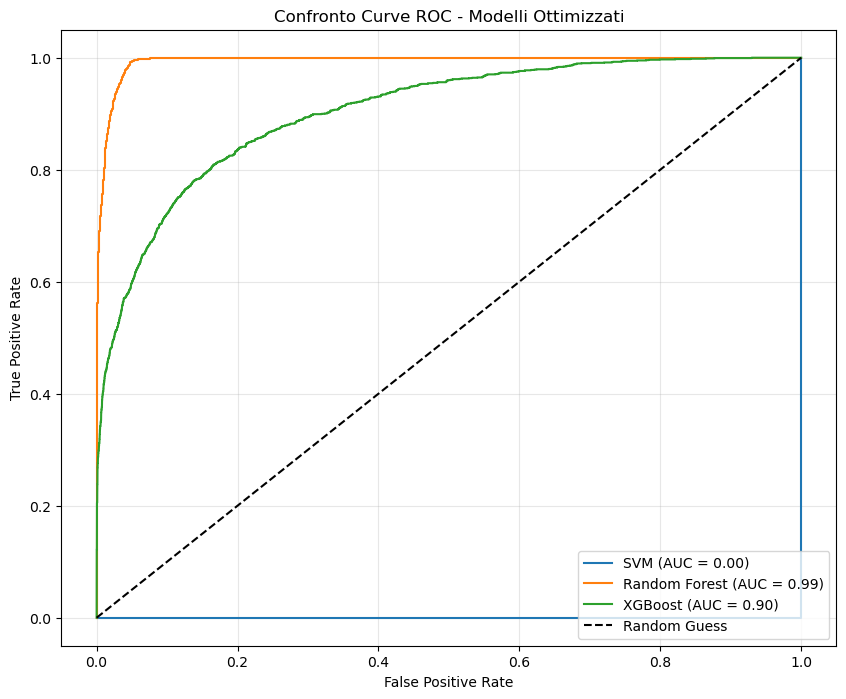

Exception ignored in: <function ResourceTracker.__del__ at 0x1047d5c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105381c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x118069c60>
Traceback (most recent call last

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

models = {
    'SVM': opt_svm.best_estimator_,
    'Random Forest': opt_rf.best_estimator_,
    'XGBoost': opt_xgb.best_estimator_
}

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X)[:, 1]
    else:
        probs = model.decision_function(X)
    
    fpr, tpr, _ = roc_curve(y, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Confronto Curve ROC - Modelli Ottimizzati')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()